In [19]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, r2_score, mean_squared_error

In [20]:
#Load the dataset
df = pd.read_csv("HR_Dataset.csv")
df.head()


,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,10026,0,0,1,1,5,4,0,62506,0,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,10084,1,1,1,5,3,3,0,104437,1,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,10196,1,1,0,5,5,3,0,64955,1,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,10088,1,1,0,1,5,3,0,64991,0,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,01/03/2019,0,15
4,10069,0,2,0,5,5,3,0,50825,1,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,02/01/2016,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EmpID                       311 non-null    int64  
 1   MarriedID                   311 non-null    int64  
 2   MaritalStatusID             311 non-null    int64  
 3   GenderID                    311 non-null    int64  
 4   EmpStatusID                 311 non-null    int64  
 5   DeptID                      311 non-null    int64  
 6   PerfScoreID                 311 non-null    int64  
 7   FromDiversityJobFairID      311 non-null    int64  
 8   Salary                      311 non-null    int64  
 9   Termd                       311 non-null    int64  
 10  PositionID                  311 non-null    int64  
 11  Position                    311 non-null    object 
 12  State                       311 non-null    object 
 13  Zip                         311 non

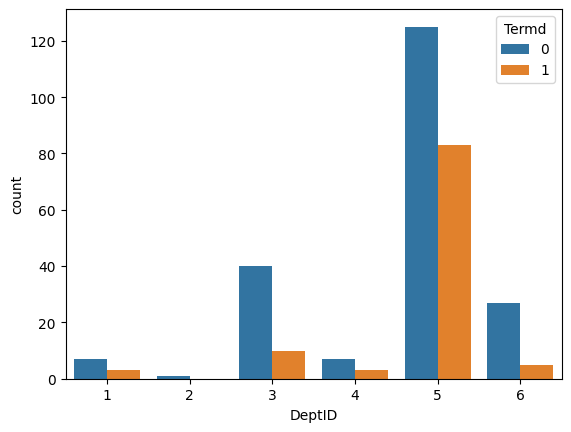

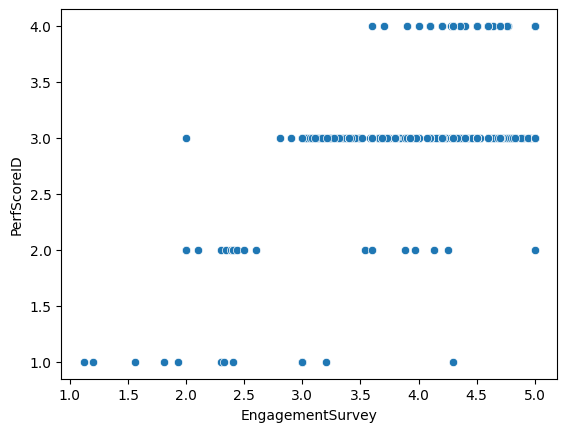

In [21]:
#Exploratory Data Analysis(EDA)
df.info()
df.describe()
df['Termd'].value_counts()

#Plots
sns.countplot(x='DeptID', hue='Termd', data=df)
plt.show()

sns.scatterplot(x='EngagementSurvey', y='PerfScoreID', data=df)
plt.show()


In [22]:
#Data Preprocessing
# Separate features and target for classification (attrition)
X = df.drop(columns=['Termd', 'PerfScoreID'])
y_class = df['Termd']

# Separate features and target for regression (performance)
y_reg = df['PerfScoreID']

# Identify categorical & numerical features
categorical = X.select_dtypes(include=['object', 'category']).columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ])


In [23]:
#Classification Model(Employee Attrition)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        22

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

ROC AUC: 1.0


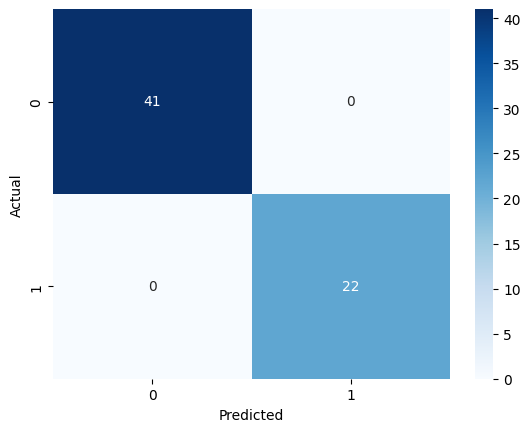

In [24]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
#Regression Model(Performance Prediction)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

reg_pipeline.fit(X_train_r, y_train_r)
y_pred_r = reg_pipeline.predict(X_test_r)

print("R² Score:", r2_score(y_test_r, y_pred_r))
print("Mean Squared Error:", mean_squared_error(y_test_r, y_pred_r))


R² Score: 0.9779611307420495
Mean Squared Error: 0.003142857142857142


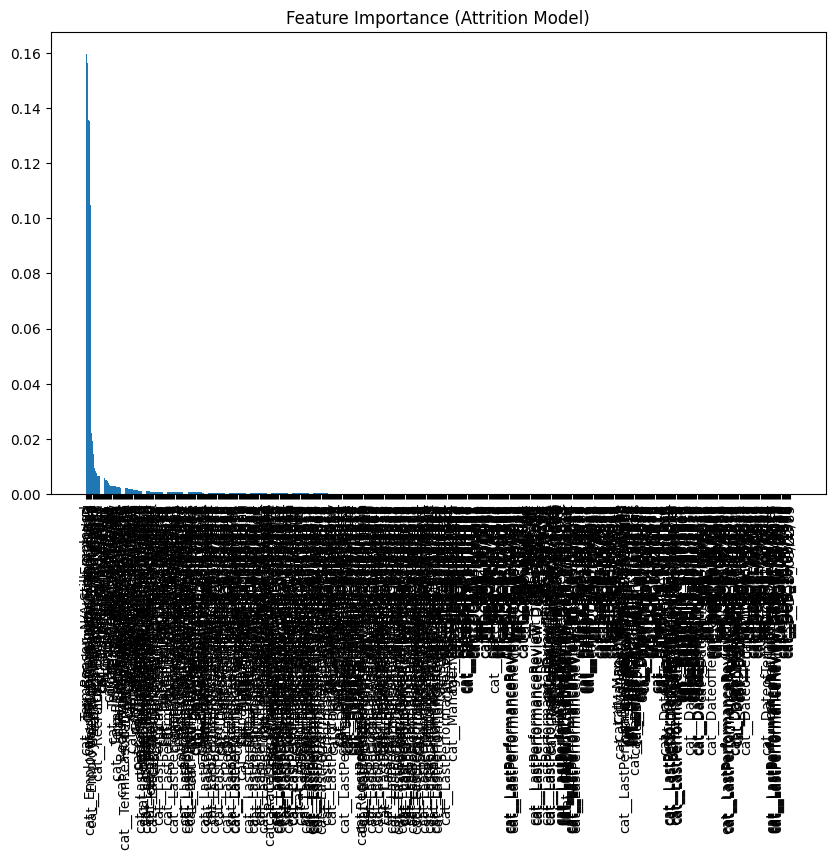

In [26]:
#Feature Importance(from Classifier)
model = clf_pipeline.named_steps['classifier']
feature_names = clf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Feature Importance (Attrition Model)")
plt.show()
